In [1]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

In [3]:
from transformers import AutoModel, AutoTokenizer

model_name = "allegro/herbert-base-cased"         
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from t

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
from datasets import load_dataset

dataset = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'phrases', 'wsd'],
        num_rows: 7848
    })
})

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

texts = [example["text"] for example in dataset["train"].select(range(300))]  # Przykładowo 100 zdań


embeddings = []
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    embeddings.append(cls_embedding)

embeddings = np.vstack(embeddings)

cosine_similarities = cosine_similarity(embeddings)

similarity_values = cosine_similarities[np.triu_indices_from(cosine_similarities, k=1)]

mean_similarity = np.mean(similarity_values)
std_similarity = np.std(similarity_values)

print(f"Średnie podobieństwo cosinusowe: {mean_similarity}")
print(f"Odchylenie standardowe: {std_similarity}")


Średnie podobieństwo cosinusowe: 0.8991789221763611
Odchylenie standardowe: 0.023798739537596703


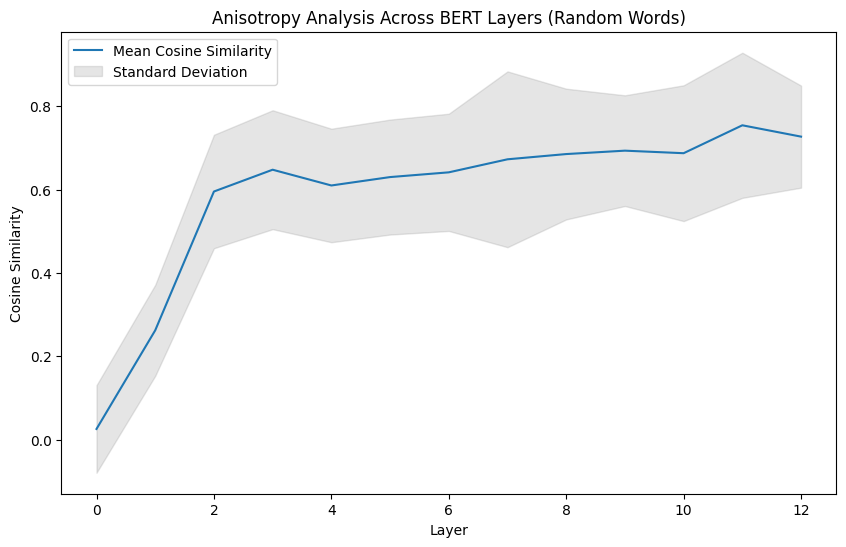

In [9]:
layer_similarities = {}

model.config.output_hidden_states = True

layer_similarities = {}

for text in texts:

    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model(**inputs)

    input_ids = inputs["input_ids"][0].tolist()
    random_word_index = random.randint(1, len(input_ids) - 2)


    for layer_index, hidden_state in enumerate(outputs.hidden_states):
        word_embedding = hidden_state[0, random_word_index, :].detach().numpy()

        if layer_index not in layer_similarities:
            layer_similarities[layer_index] = []

        layer_similarities[layer_index].append(word_embedding)


mean_similarities = []
std_similarities = []

for layer_index, embeddings in layer_similarities.items():
    embeddings = np.vstack(embeddings)
    cosine_similarities = cosine_similarity(embeddings)
    similarity_values = cosine_similarities[np.triu_indices_from(cosine_similarities, k=1)]

    mean_similarity = np.mean(similarity_values)
    std_similarity = np.std(similarity_values)

    mean_similarities.append(mean_similarity)
    std_similarities.append(std_similarity)


layers = list(range(len(mean_similarities)))

plt.figure(figsize=(10, 6))
plt.plot(layers, mean_similarities, label='Mean Cosine Similarity')
plt.fill_between(layers,
                 np.array(mean_similarities) - np.array(std_similarities),
                 np.array(mean_similarities) + np.array(std_similarities),
                 color='gray', alpha=0.2, label='Standard Deviation')
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.title("Anisotropy Analysis Across BERT Layers (Random Words)")
plt.legend()
plt.show()

# (Context-Specificity)

In [10]:
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
from datasets import load_dataset
from collections import Counter


In [19]:

dataset = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)

model_name = "allegro/herbert-base-cased"         
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
examples = dataset['train'].select(range(5))
for example in examples:
    print(example)

{'text': 'Zatem to pani siostra o niego prosiła? Skądże, nigdy nie słyszałam, żeby go używała. Zwykłyśmy obywać się bez służących. W istocie, wydaje się niepotrzebnym umieszczanie tak porządnego sznura w tym miejscu. Bądźcie teraz tak uprzejmi i dajcie mi kilka minut na bliższe zapoznanie się z podłogą. Holmes przypadł do podłogi, pełzał w te i wewte ze szkłem powiększającym w dłoni, ze skupieniem badając przerwy między deskami. Następnie w podobny sposób przyjrzał się deskom na ścianach komnaty. Potem podszedł do łóżka i przez jakiś czas przyglądał się uważnie zarówno jemu, jak i przylegającej doń ścianie. Wreszcie chwycił sznur i energicznie go pociągnął. Ależ to przecież atrapa - powiedział. Nie dzwoni? Bynajmniej, nie jest nawet połączony z drucikiem. Niezwykle interesujące. Zwróćcie uwagę, proszę, że jest podpięty do haka tuż nad niewielkim otworem pełniącym funkcję wywietrznika. Toż to niedorzeczne! Nie zauważyłam tego wcześniej. Bardzo dziwne - wymamrotał Holmes, pociągając za s

In [21]:

texts = [example["text"] for example in dataset['train']]

all_text = " ".join(texts)

words = re.findall(r'\b\w+\b', all_text.lower())

word_counts = Counter(words)

word_counts

Counter({'w': 28311,
         'i': 20480,
         'się': 17198,
         'na': 16060,
         'z': 15307,
         'nie': 11814,
         'do': 11411,
         'to': 8493,
         'że': 8371,
         'jest': 7017,
         'o': 6533,
         'a': 4832,
         'jak': 3861,
         'po': 3562,
         'od': 3456,
         'tym': 3301,
         'za': 3274,
         'przez': 2840,
         'co': 2693,
         'ale': 2547,
         'dla': 2498,
         'tego': 2370,
         'tak': 2311,
         'są': 2020,
         'jego': 1984,
         'już': 1980,
         'który': 1975,
         'czy': 1881,
         'oraz': 1869,
         'mnie': 1762,
         'ma': 1760,
         'ze': 1738,
         'lub': 1632,
         'tylko': 1612,
         'może': 1604,
         'bardzo': 1512,
         'ich': 1467,
         'jej': 1399,
         '1': 1379,
         'go': 1370,
         'był': 1362,
         'ten': 1346,
         'mi': 1334,
         'roku': 1317,
         'które': 1315,
         '

In [76]:
words_list = ['skład', 'wielkie', 'droga', 'połowie', 'wolno']

In [77]:


sentences_with_words = {word: [] for word in words_list}

for example in dataset['train']:
    text = example["text"]
    for word in words_list:
        if re.search(rf"\b{word}\b", text):
            sentences_with_words[word].append(text)

for word, sentences in sentences_with_words.items():
    print(f"\nZdania zawierające słowo '{word}':")
    for sentence in sentences[:5]:
        print("-", sentence)



Zdania zawierające słowo 'skład':
- Do tych starych zarzutów można dopisać wiele następnych. Na razie to tylko plany. Licytacja, tych rzeczy, prowadzoną w ramach Wielkiego Żółtego Odrzutowego Happeningu, rozpoczęła się od kwoty 20 zł. Trwają już negocjacje z prezesami spółek wchodzących w skład ŚFUP-u. Wczoraj o godz. 8.30 prezesi spotkali z załogami spółek, żeby przekazać ustalenia. Zdaniem Wiesława Rybińskiego, nie wszędzie odbyło się to rzetelnie. - A to jest nieprawda. My działamy w imieniu załogi i dla nich, więc żądania dotyczą wszystkich. W efekcie mają powstać nowoczesne wsie zdolne konkurować w ramach Unii Europejskiej . Gdzie jest chorąży? W poniedziałek Sąd Garnizonowy we Wrocławiu oddalił zarzuty prokuratury wobec żołnierza. Zarzut dotyczył czterokrotnego usiłowania zabójstwa. Sąd nie uwzględnił również wniosku prokuratury o tymczasowym aresztowaniu marynarza. W razie uszkodzenia zadziała automatyczny system ochrony. Na szczycie 25-metrowej wieży zamontowano przed kilkoma 

Subtoken 'skład</w>' nie został znaleziony w zdaniu: Łatwość, z jaką powstają mieszańce, przemawia za młodym wiekiem całej rodziny storczykowatych. W 20 polach diagramu ukryto skarby. Cyfra w danym polu oznacza, w ilu sąsiednich kratkach stykających się z polem z cyfrą bokiem lub rogiem znajdują się skarby. W kratkach z cyframi skarbów nie ma. Oznacz wszystkie pola ze skarbami. W rozwiązaniu wystarczy podać, ile skarbów znajduje się na przekątnych diagramu. Dzięki temu przekonano się, że galaktyki aktywne nie tworzą jednolitej grupy, ale mają dość zróżnicowane własności. W ostatnich latach udało się jednak wyjaśnić zauważone różnice i zaproponować model wspólny dla wszystkich obiektów aktywnych. Powstał w ten sposób schemat ich unifikacji. Roztwory tłoczone są do baterii w obiegu zamkniętym z dwóch osobnych zbiorników. Po rozładowaniu akumulatora można go ponownie naładować lub po prostu wymienić roztwory na już naładowane. Oddając zużyte elektrolity, które tam będą regenerowane, napeł

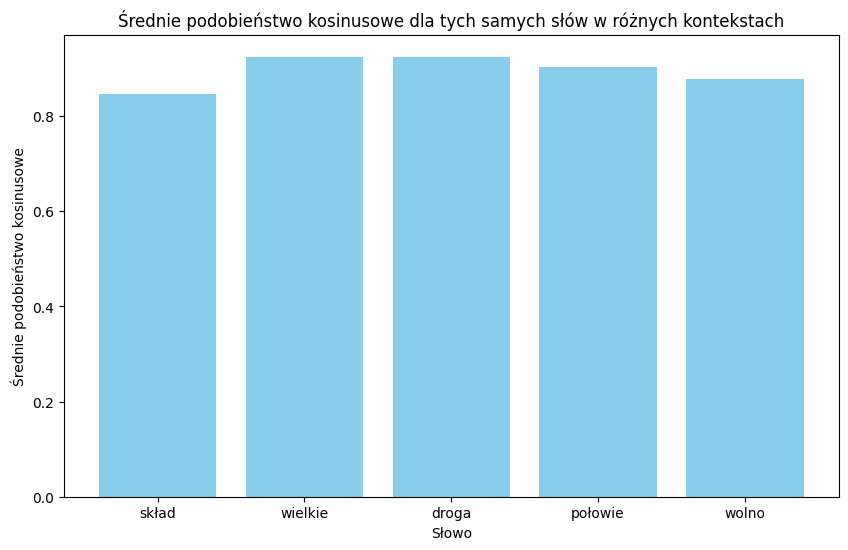

In [79]:
word_embeddings = {word: [] for word in words_list}


model.eval()
with torch.no_grad():
    for word, sentences in sentences_with_words.items():
        for sentence in sentences:
            
            inputs = tokenizer(sentence, return_tensors="pt", max_length=128, truncation=True)
            
            outputs = model(**inputs, output_hidden_states=True)
            
            hidden_states = outputs.hidden_states[-1] 

            tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
            subtokens = tokenizer.tokenize(word)

            try:
                token_index = tokens.index(subtokens[0])
                word_embedding = hidden_states[0][token_index]
                word_embeddings[word].append(word_embedding.cpu().numpy())
            except ValueError:
                print(f"Subtoken '{subtokens[0]}' nie został znaleziony w zdaniu: {sentence}")
                continue


average_similarities = {}
for word, embeddings in word_embeddings.items():
    if len(embeddings) > 1:

        similarities = cosine_similarity(embeddings)
        avg_similarity = np.mean(similarities[np.triu_indices_from(similarities, k=1)])
        average_similarities[word] = avg_similarity
    else:
        print(f"Niewystarczająca liczba przykładów dla słowa '{word}'")


words = list(average_similarities.keys())
similarities = list(average_similarities.values())

plt.figure(figsize=(10, 6))
plt.bar(words, similarities, color='skyblue')
plt.xlabel("Słowo")
plt.ylabel("Średnie podobieństwo kosinusowe")
plt.title("Średnie podobieństwo kosinusowe dla tych samych słów w różnych kontekstach")
plt.show()

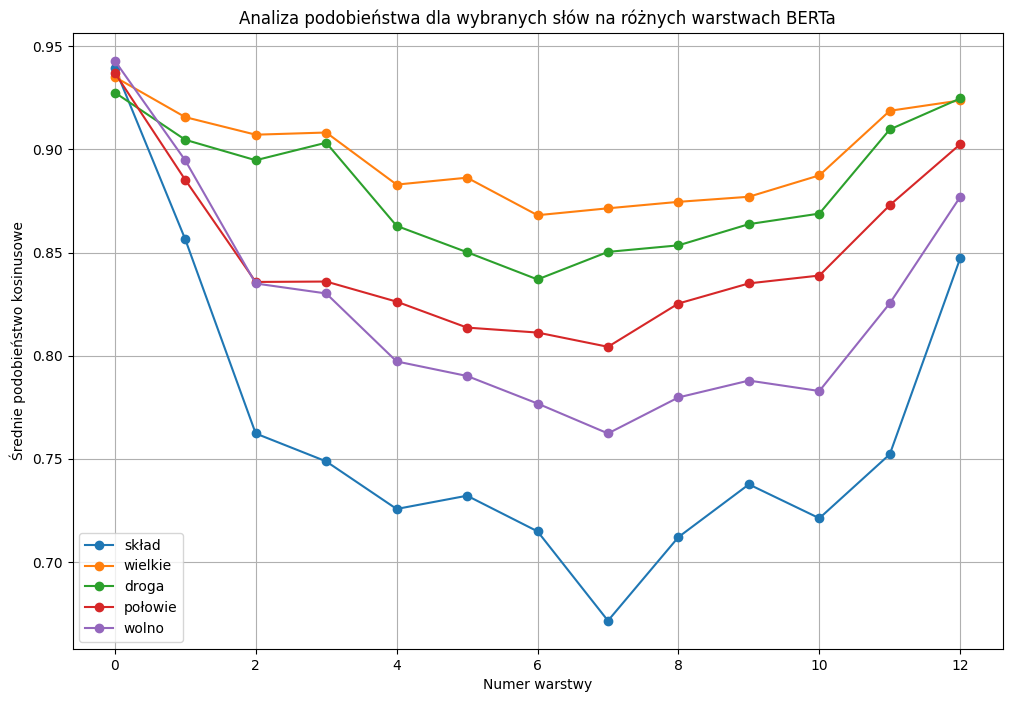

In [80]:
layer_similarities = {word: [0] * 13 for word in words_list}  # Inicjalizuj listę 13 zer dla każdej warstwy

# Ustawienie modelu w tryb ewaluacji
model.eval()

with torch.no_grad():
    for word, sentences in sentences_with_words.items():
        for layer in range(13):  
            embeddings = []

            for sentence in sentences:
                inputs = tokenizer(sentence, return_tensors="pt", max_length=128, truncation=True)
                outputs = model(**inputs, output_hidden_states=True)

                hidden_state = outputs.hidden_states[layer]
                tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
                subtokens = tokenizer.tokenize(word)

                try:
                    token_index = tokens.index(subtokens[0])
                    word_embedding = hidden_state[0][token_index]
                    embeddings.append(word_embedding.cpu().numpy())
                except ValueError:
                    continue

            if len(embeddings) > 1:
                similarities = cosine_similarity(embeddings)
                avg_similarity = np.mean(similarities[np.triu_indices_from(similarities, k=1)])
                layer_similarities[word][layer] = avg_similarity
            else:
                layer_similarities[word][layer] = 0

# Tworzenie wykresu
plt.figure(figsize=(12, 8))
for word, similarities in layer_similarities.items():
    plt.plot(range(13), similarities, marker='o', label=word)

plt.xlabel("Numer warstwy")
plt.ylabel("Średnie podobieństwo kosinusowe")
plt.title("Analiza podobieństwa dla wybranych słów na różnych warstwach BERTa")
plt.legend()
plt.grid(True)
plt.show()
